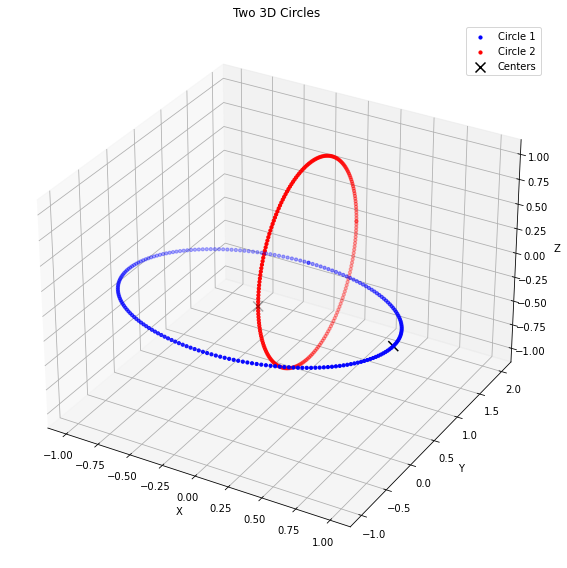

Weights Gradients:
Layer 0: tensor([[-4.0060e-03,  2.3958e-02,  4.0294e-03],
        [ 1.9626e-03,  2.5969e-02, -2.8885e-03],
        [-4.1703e-04,  4.7406e-02,  5.7480e-03],
        [-3.3843e-03,  1.6685e-02, -2.3014e-03],
        [-2.7765e-03,  2.3217e-02, -4.4851e-03],
        [-3.1357e-03,  2.3314e-02, -4.9952e-04],
        [-3.5864e-03,  6.4022e-03,  3.8359e-03],
        [-1.3142e-03,  4.3679e-02, -3.6748e-04],
        [-3.1691e-03,  1.8501e-02, -5.5160e-03],
        [-1.5712e-03,  1.3470e-02, -1.9104e-03],
        [-2.1787e-04,  2.2191e-02,  2.4716e-03],
        [-1.5098e-03,  2.2268e-02,  2.1091e-03],
        [ 1.6197e-05,  3.2930e-02,  1.6083e-03],
        [ 1.9306e-03,  4.0845e-02,  3.1541e-03],
        [-2.3515e-03,  2.6749e-02, -9.7466e-04],
        [-3.4732e-03,  4.7147e-02, -5.3569e-03],
        [-8.7757e-04,  4.0728e-02,  6.7479e-03],
        [-9.5380e-04,  4.2798e-02,  3.1548e-03],
        [-9.2534e-04,  4.9759e-02, -4.3193e-04],
        [-4.0387e-03,  1.7009e-02,  3.970

In [3]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from model import EnergyBasedModel as EBM

import matplotlib.pyplot as plt

def generate_3d_circle_data(center, radius, normal_vector, num_points=100):
    """
    Generate points on a 3D circle with given center, radius, and normal vector.
    
    Parameters:
    - center: 3D coordinates of circle center
    - radius: radius of the circle
    - normal_vector: normal vector to the circle plane
    - num_points: number of points to generate
    
    Returns:
    - points on the circle
    """
    # Normalize the normal vector
    normal = np.array(normal_vector)
    normal = normal / np.linalg.norm(normal)
    
    # Find two orthogonal vectors in the circle plane
    if np.allclose(normal, [1, 0, 0]):
        v1 = np.array([0, 1, 0])
    else:
        v1 = np.cross(normal, [1, 0, 0])
        v1 = v1 / np.linalg.norm(v1)
    
    v2 = np.cross(normal, v1)
    v2 = v2 / np.linalg.norm(v2)
    
    # Generate circle points
    theta = np.linspace(0, 2 * np.pi, num_points)
    circle_points = center + radius * (np.outer(np.cos(theta), v1) + np.outer(np.sin(theta), v2))
    
    return circle_points

# Create the dataset
def create_circles_dataset(num_points=100):
    # Circle 1: centered at the origin, on the xy-plane
    center1 = np.array([0, 0, 0])
    radius1 = 1.0
    normal1 = np.array([0, 0, 1])  # Normal to xy-plane
    
    # Circle 2: centered at (0, 1, 0), on the yz-plane (perpendicular to Circle 1)
    center2 = np.array([0, 1, 0])
    radius2 = 1.0
    normal2 = np.array([1, 0, 0])  # Normal to yz-plane
    
    # Generate points
    circle1_points = generate_3d_circle_data(center1, radius1, normal1, num_points)
    circle2_points = generate_3d_circle_data(center2, radius2, normal2, num_points)
    
    # Combine into a dataset with labels
    X = np.vstack([circle1_points, circle2_points])
    y = np.array([0] * num_points + [1] * num_points)
    
    return X, y

# Generate the dataset
X, y = create_circles_dataset(num_points=200)

# Visualize
def visualize_circles(X, y):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points for each circle
    colors = ['blue', 'red']
    for i, color in enumerate(colors):
        mask = (y == i)
        ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2], c=color, s=10, label=f'Circle {i+1}')
    
    # Add circle centers
    centers = [np.array([0, 0, 0]), np.array([1, 0, 0])]
    ax.scatter([c[0] for c in centers], [c[1] for c in centers], [c[2] for c in centers], 
               c='black', s=100, marker='x', label='Centers')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Two 3D Circles')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Visualize the dataset
visualize_circles(X, y)

# Now you can use this dataset (X, y) for training your model.
# Test, train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
import torch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
# Create a DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Define the model 
model_config = {
    'input_size': 3,  # 3D input
    'hidden_sizes': [32, 2],  # Hidden layer sizes
    'beta': 0.1,  # Temperature parameter
    'dt': 0.01,   # Step size
    'n_steps': 10  # Number of steps
}

model = EBM(
    input_size=model_config['input_size'],
    hidden_sizes=model_config['hidden_sizes'],
    beta=model_config['beta'],
    dt=model_config['dt'],
    optimizer=None,  # Optimizer will be set separately
    n_steps=model_config['n_steps']
)

# Define the optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Set the optimizer in the model
model.optimizer = optimizer
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    targets = []
    preds = []
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        preds.append(output)
        targets.append(batch_y)
    accuracy = (torch.cat(preds).argmax(dim=1) == torch.cat(targets)).float().mean()
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy.item():.4f}")

for batch_X, batch_y in test_loader:
    with torch.no_grad():
        output = model(batch_X)
        preds.append(output)
        targets.append(batch_y)
accuracy = (torch.cat(preds).argmax(dim=1) == torch.cat(targets)).float().mean()
print(f"Test Accuracy: {accuracy.item():.4f}")


In [2]:
model.states[-1]

tensor([[0.7462, 0.5635],
        [1.0044, 0.5266],
        [0.5852, 0.6654],
        [0.1369, 0.3500],
        [0.3875, 0.5967],
        [0.3503, 0.1660],
        [0.3257, 0.9605],
        [0.5277, 0.1067],
        [0.7359, 0.7476],
        [0.6065, 1.0038],
        [0.4815, 1.0045],
        [0.9189, 0.3106],
        [0.3412, 0.5391],
        [0.5793, 0.8001],
        [0.8517, 0.5397],
        [0.3919, 0.8106]])